# Finds the reference energies for the initial H5 dataset
The initial dataset can be found here: 
https://springernature.figshare.com/articles/dataset/ANI-1x_Dataset_Release/10047041?backTo=/collections/The_ANI-1ccx_and_ANI-1x_data_sets_coupled-cluster_and_density_functional_theory_properties_for_molecules/4712477

In [2]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
import json
import h5py
from ase import units
import matplotlib.pylab as plt

In [3]:
method = 'wb97x_dz'
ref_file = Path(f'../data/{method}-reference_energies.json') #Where to save reference energies
data_file = Path('../data/raw-data/ani1x-release.h5') #The origonal h5 file

Create a pandas dataset that contains formula, count of each atom, and minimum energy for each molecule in the dataset

In [4]:
records = {}  # name -> entry
with h5py.File(data_file, 'r') as original_data:
        # Loop over each composition
        for composition, page in original_data.items():
            c = Counter(page["atomic_numbers"][:])
            c = {str(key): value for key, value in c.items()}
            record = dict(c)
            record["name"] = composition
            all_energies = page[f"{method}.energy"]
            for i, coords in enumerate(page["coordinates"]):
                record["energy"] = all_energies[i] * units.Ha
                if composition not in records or \
                        record['energy'] < records[composition]['energy']:
                    records[composition] = record

records = pd.DataFrame(records).T

In [5]:
records.head(5)

,6,1,name,energy,7,8
C10H10,10,10,C10H10,-10520.540471,NaN,NaN
C10H10N2,10,10,C10H10N2,-13505.850326,2,NaN
C10H10N2O1,10,10,C10H10N2O1,-15544.826008,2,1
C10H10N2O2,10,10,C10H10N2O2,-17587.740457,2,2
C10H10N4,10,10,C10H10N4,-16486.386689,4,NaN


In [6]:
elem_columns = [c for c in records.columns if len(c) < 3]   # I know the non-element columns have names with >3 characters
print(f'We found {len(elem_columns)} elements: {elem_columns}')

We found 4 elements: ['6', '1', '7', '8']


Sets NaNs to zero 

In [7]:
x = np.array(records[elem_columns].values, dtype=float)
x[np.isnan(x)] = 0

Find the reference energies using linear regression

In [8]:
model = RANSACRegressor(estimator=LinearRegression(fit_intercept=False)).fit(x, records['energy'])
ref_energies = dict(zip(elem_columns, model.estimator_.coef_))
ref_energies

{'6': -1036.4229994877442,
 '1': -16.416875389564442,
 '7': -1489.0214566692116,
 '8': -2045.9142867982007}

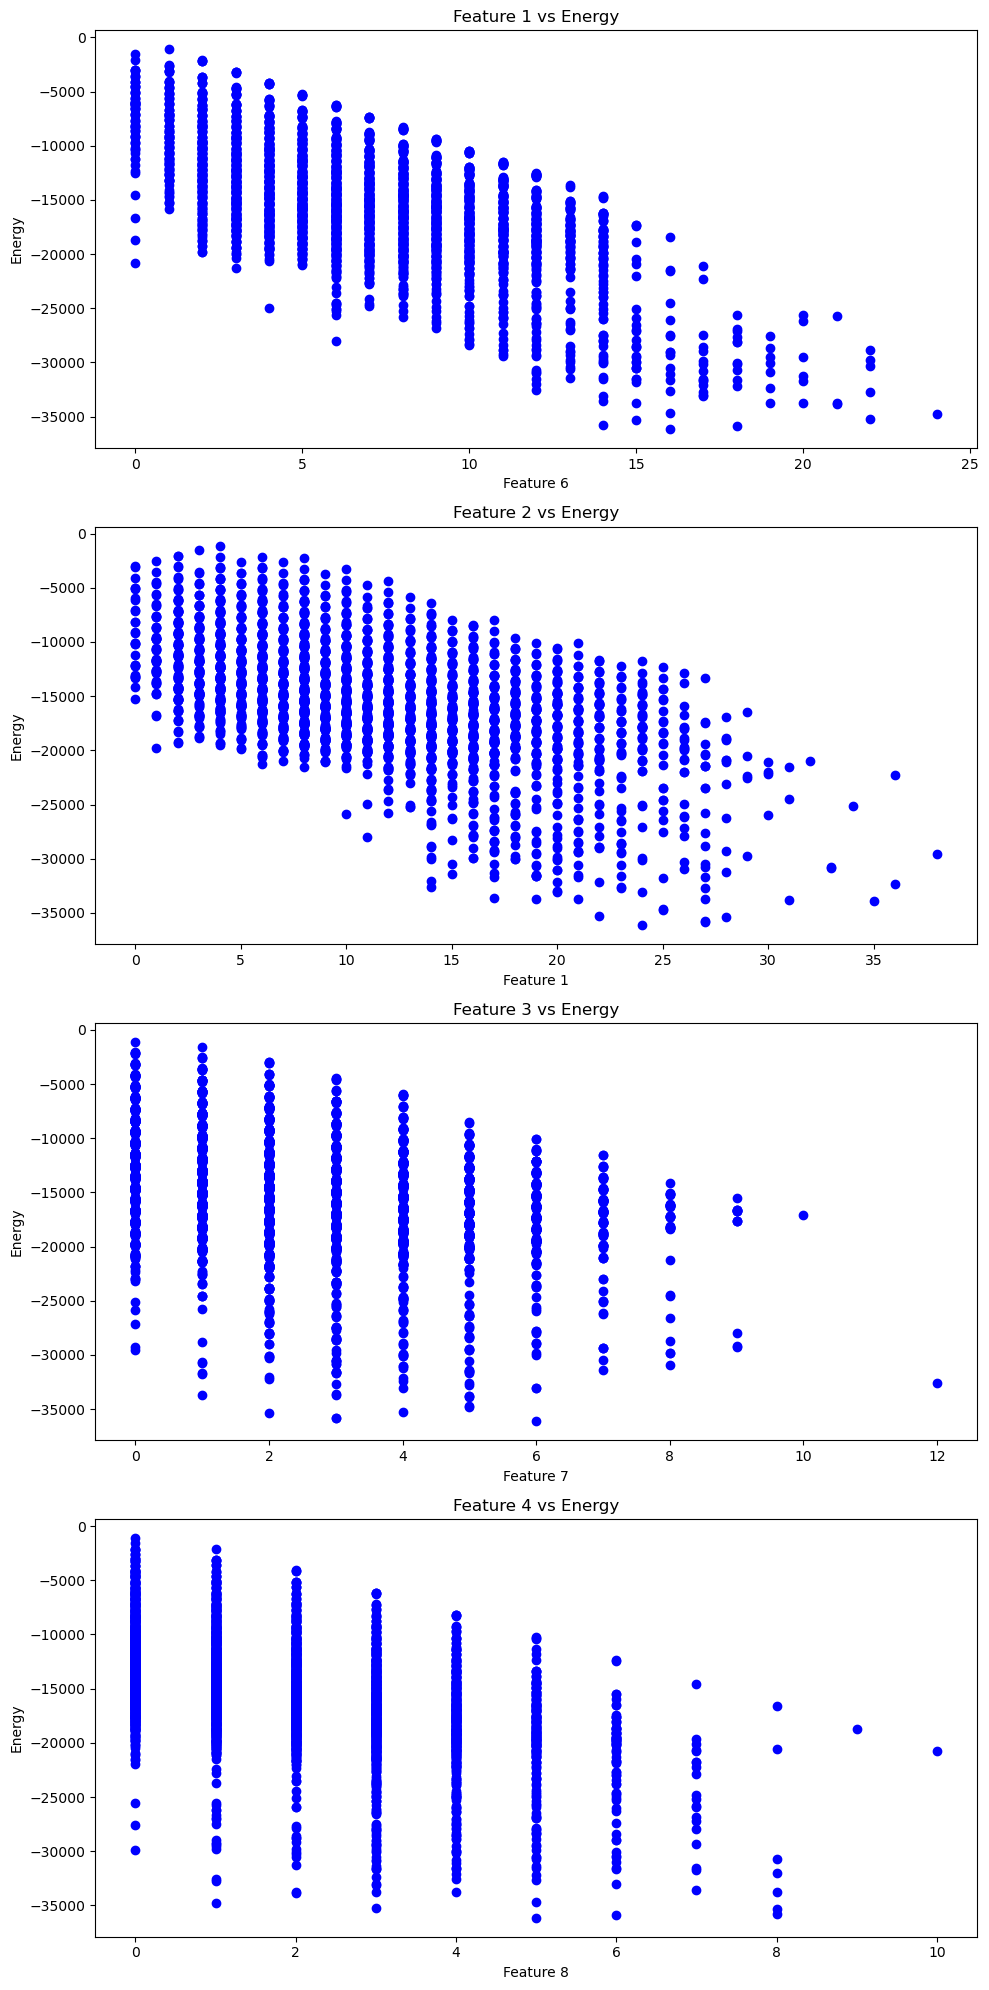

In [18]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# For each feature in x, plot it against records['energy']
for i in range(4):
    axs[i].scatter(x[:, i], records['energy'], color='blue', marker='o')
    axs[i].set_title(f'Atom {elem_columns[i]} vs Energy')
    axs[i].set_xlabel(f'Atom {elem_columns[i]}')
    axs[i].set_ylabel('Energy')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
if ref_file.exists():
    ref_data = json.loads(ref_file.read_text())

In [ ]:
ref_file.write_text(json.dumps(ref_energies, indent=2))

114